In [1]:
import numpy as np
import matplotlib.pyplot as plt
from geodesic_toolbox import *
import torch
from torch import Tensor
from utils import plot_traj

# Slope metric

In [66]:
l = 2.0
x = torch.linspace(-l, l, 100)
y = torch.linspace(-l, l, 100)
X, Y = torch.meshgrid(x, y)

In [67]:
def f(X: Tensor) -> Tensor:
    """Height map function.

    Parameters
    ----------
    X : Tensor (N,2)
        Input tensor with shape (N, 2) where N is the number of points.

    Returns
    -------
    Tensor
        Output tensor with shape (N,) representing the height at each point.
    """
    Z = -X[:, 0] ** 2 - X[:, 1] ** 2
    return Z


# def f(X: Tensor) -> Tensor:
#     Z = X[:, 0] ** 2 + X[:, 1] ** 2
#     c = 1 / (2 * torch.sqrt(torch.tensor(6)))
#     return c * torch.exp(-Z)


# def f(X: Tensor) -> Tensor:
#     Z = (X[:, 0] + X[:, 1]) ** 2
#     c = 1 / (2 * torch.sqrt(torch.tensor(6)))
#     return c * torch.exp(-Z)


def f(X: Tensor) -> Tensor:
    x, y = X[:, 0], X[:, 1]
    c = 1 / (2 * torch.sqrt(torch.tensor(6)))
    Z = c * torch.log(torch.sqrt((x + y) ** 2 + 1) + x + y)
    return Z


# def f(X: Tensor) -> Tensor:
#     Z = torch.arctan(X[:, 0] + X[:, 1])
#     c = 1 / (2 * torch.sqrt(torch.tensor(6)))
#     return c * Z


X_ = torch.stack([X.flatten(), Y.flatten()], dim=1).requires_grad_(True)
Z = f(X_).reshape(X.shape)

In [68]:
metric = SlopeMetrics(f=f)

In [69]:
v = 4 * torch.ones(X_.shape[0], 2)  # Random vector field
F = metric(X_, v).detach()

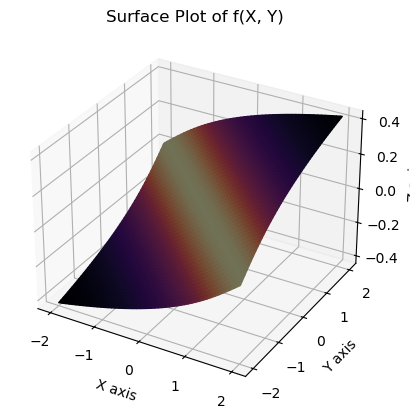

In [70]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
from matplotlib import cm

# F_plt = (F / F.max()).reshape(X.shape)
F_plt = ((F - F.min()) / (F.max() - F.min())).reshape(X.shape)
cmap = cm.magma(F_plt)
ax.plot_surface(
    X.numpy(),
    Y.numpy(),
    Z.detach().numpy(),
    facecolors=cmap,
)
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
plt.title("Surface Plot of f(X, Y)")
plt.show()

In [71]:
q0 = torch.tensor([[0.0, -1.0]]).requires_grad_(True)
q1 = torch.tensor([[0.3, 0.0]]).requires_grad_(True)

solver = GEORCEFinsler(metric, pbar=True)

traj = solver.get_trajectories(q0, q1).squeeze(0).detach()
traj_back = solver.get_trajectories(q1, q0).squeeze(0).detach()

dst_forward = solver.dst_func(q0[0], q1[0], traj[1:-1])
dst_backward = solver.dst_func(q1[0], q0[0], traj_back[1:-1])

print(f"Forward distance: {dst_forward.item()}")
print(f"Backward distance: {dst_backward.item()}")

i=001 | alpha: 1.000E+00, E = 1.909E-02, grad_E = 8.234E-08,  dst = 1.382E+00:   0%|          | 1/200 [00:00<00:26,  7.52it/s]
Iterations:   0%|          | 0/200 [00:00<?, ?it/s]


Forward distance: 1.3816595077514648
Backward distance: 0.8754500150680542


Forward distance q0->q1  : 1.38
Backward distance q1->q0 : 0.88


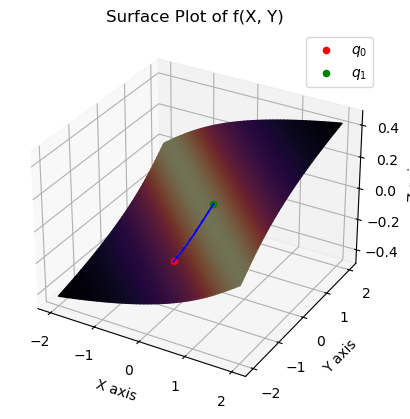

In [72]:
print(f"Forward distance q0->q1  : {dst_forward.item():.2f}")
print(f"Backward distance q1->q0 : {dst_backward.item():.2f}")

fig = plt.figure()
ax = plt.axes(projection="3d", computed_zorder=False)
F_plt = ((F - F.min()) / (F.max() - F.min())).reshape(X.shape)
cmap = cm.magma(F_plt)
ax.plot_surface(
    X.numpy(),
    Y.numpy(),
    Z.detach().numpy(),
    facecolors=cmap,
)
ax.scatter(q0[0, 0].item(), q0[0, 1].item(), f(q0).item(), color="red", label=r"""$q_0$""")
ax.scatter(q1[0, 0].item(), q1[0, 1].item(), f(q1).item(), color="green", label=r"""$q_1$""")
ax.plot(
    traj_back[:, 0],
    traj_back[:, 1],
    f(traj_back),
    linestyle="--",
    color="orange",
    # label="Backward Trajectory",
)
ax.plot(
    traj[:, 0],
    traj[:, 1],
    f(traj),
    linestyle="-",
    color="blue",
    # label="Forward Trajectory",
)

ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
plt.title("Surface Plot of f(X, Y)")
plt.legend()
plt.show()

# Asymetric distances

In [241]:
l = 2.5
res = 50
x = torch.linspace(-l, l, res)
y = torch.linspace(-l, l, res)
X, Y = torch.meshgrid(x, y)
X_ = torch.stack([X.flatten(), Y.flatten()], dim=1)

Computing magnification factor: 100%|██████████| 79/79 [00:00<00:00, 968.50batch/s]


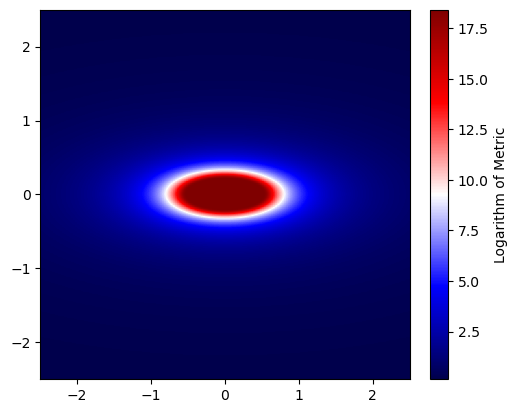

In [242]:
class HoleCometric(CoMetric):
    """A cometric that is zero inside a hole and one outside."""

    def __init__(self, skew_mat, lbda=1e-4, temp: float = 1.0):
        super().__init__()
        self.skew_mat = skew_mat
        self.lbda = lbda
        self.temp = temp

    def rho(self, X: Tensor) -> Tensor:
        """Compute the length of the vector field at points X.
        Length is between 0 and 1 (excluding both).
        """

        dz = torch.einsum("bi,ij,bj->b", X, self.skew_mat, X) / self.temp
        rho_ = torch.exp(-1 / (dz * 2.0 + 1e-5))
        # rho_ = torch.nn.functional.softplus(rho_, beta=10.0, threshold=0.5)
        return rho_

    def forward(self, X: Tensor) -> Tensor:
        """Compute the cometric at points X."""
        rho_ = self.rho(X)
        id = self.eye(X)
        g_inv = rho_[:, None, None] * id
        return g_inv + self.lbda * self.eye(X)


device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
skew_mat = torch.eye(2).to(device)
skew_mat[0, 0] = 1 / 6
base_cometric = HoleCometric(skew_mat.to(device), temp=2, lbda=1e-8).to(device)
# base_cometric = IdentityCoMetric().to(device)  # For testing purposes, use identity cometric
extent = (-l, l, -l, l)
mf = get_mf_image(base_cometric, bounds=extent, device=device)

im = plt.imshow(mf.log(), cmap="seismic", extent=extent, origin="lower")
plt.colorbar(im, label="Logarithm of Metric", fraction=0.2, pad=0.04)
plt.show()

In [243]:
class OmegaField(torch.nn.Module):
    def __init__(self, base_cometric: CoMetric, skew_mat: Tensor = skew_mat):
        super().__init__()
        self.base_cometric = base_cometric
        self.skew_mat = skew_mat

    def rho(self, X: Tensor) -> Tensor:
        """Compute the length of the vector field at points X.
        Length is between 0 and 1 (excluding both).
        """
        # dz = torch.einsum("bi,ij,bj->b", X, self.skew_mat, X)
        # rho_ = torch.exp(-1 / (dz * 2.0 + 1e-5))
        # rho_ = torch.nn.functional.softplus(rho_, beta=10.0, threshold=0.5)
        # return rho_
        rho_ = torch.tanh(X[:, 1] * 2) ** 2
        # return rho_  # Uncomment for testing
        return torch.ones_like(rho_)  # Placeholder for testing

    def theta(self, X: Tensor, bound=l, max_angle=torch.pi / 2.5) -> Tensor:
        sign_y = torch.nn.functional.softsign(X[:, 1])
        # theta = -sign_y * max_angle / bound * X[:, 0]
        theta = sign_y * torch.tanh(-X[:, 0]) * max_angle
        return theta

    def forward(self, X: Tensor) -> Tensor:
        """Get the vector field omega at points X."""
        rho_ = self.rho(X)  # [0,1]
        theta_ = self.theta(X)
        sign_y = torch.nn.functional.softsign(X[:, 1])
        omega = sign_y[:, None] * torch.stack(
            [torch.cos(theta_), torch.sin(theta_)], dim=1
        )  # (b, 2)
        # Normalize to ensure positivity of the metric
        G_inv = self.base_cometric(X)
        omega_norm = torch.einsum("bi,bij,bj->b", omega, G_inv, omega).sqrt()
        omega = rho_[:, None] * omega / (omega_norm[:, None] + 1e-5)
        return omega


omega = OmegaField(base_cometric, skew_mat).to(device)

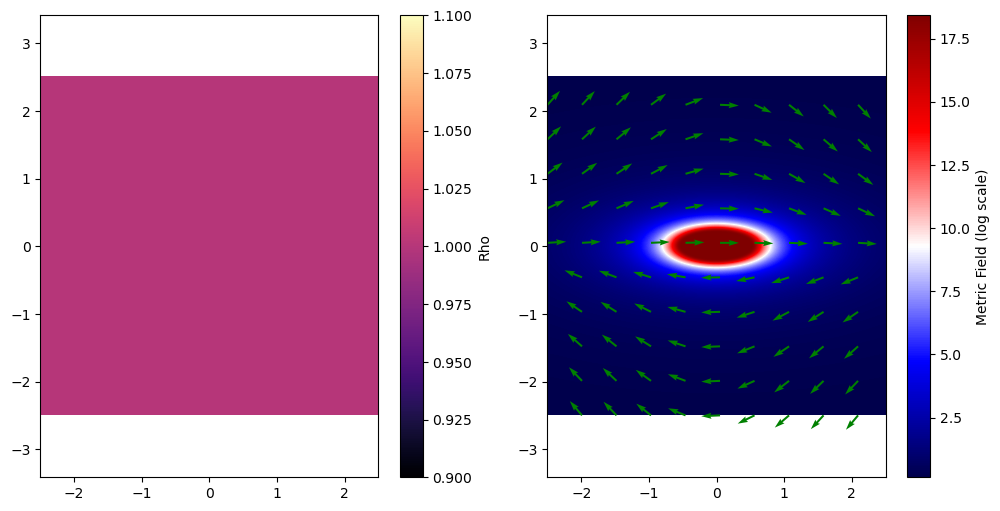

In [248]:
%matplotlib inline
plt.close()
rho_ = omega.rho(X_.to(device)).reshape(X.shape).cpu()
omega_ = OmegaField(IdentityCoMetric(), skew_mat).to(device)(X_.to(device)).reshape(X.shape + (2,)).cpu()
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))
img=ax1.imshow(
    rho_.T,
    extent=(-l, l, -l, l),
    origin='lower',
    cmap='magma'
    
)
plt.colorbar(img, ax=ax1, label='Rho')
img_mf=ax2.imshow(
    mf.log(),
    extent=extent,
    origin='lower',
    cmap='seismic',
    interpolation='bicubic'
)
plt.colorbar(img_mf, ax=ax2, label='Metric Field (log scale)')
# Subsample the vector field for better visualization
step = 5
ax2.quiver(
    X[::step, ::step].numpy(),
    Y[::step, ::step].numpy(),
    omega_[::step, ::step, 0].numpy(),
    omega_[::step, ::step, 1].numpy(),
    color="green"
)
for ax in (ax1, ax2):
    ax.axis("equal")

In [245]:
metric = RandersMetrics(base_cometric=base_cometric, omega=omega).to(device)
# solver = GEORCEFinsler(metric, pbar=True, tol=4e-5).to(device)
solver = SolverGraphGEORCEFinsler(
    metric, data=X_.to(device), pbar_georce=True, tol=4e-5, n_neighbors=8
).to(device)
# solver = SolverGraphFinsler(metric, data=X_.to(device), n_neighbors=8).to(device)

Initialize Graph:   0%|          | 0/40 [00:00<?, ?batch/s]

Initialize Graph: 100%|██████████| 40/40 [00:55<00:00,  1.38s/batch]


Computing predecessors...
Done.


In [246]:
q0 = torch.tensor([[-2.2, 0.05]]).requires_grad_(False).to(device)
q1 = torch.tensor([[2.2, -0.05]]).requires_grad_(False).to(device)

traj_0_georce_rf = solver.get_trajectories(q0, q1)
traj_1_georce_rf = solver.get_trajectories(q1, q0)

dst_0_rf = solver.dst_func(x_0=q0[0], x_t=traj_0_georce_rf[0, 1:-1], x_T=q1[0])
dst_1_rf = solver.dst_func(x_0=q1[0], x_t=traj_1_georce_rf[0, 1:-1], x_T=q0[0])
# dst_0_rf = solver.compute_distance(traj_0_georce_rf)
# dst_1_rf = solver.compute_distance(traj_1_georce_rf)

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

i=001 | alpha: 7.889E-31, E = 5.064E+06, grad_E = NAN,  dst = 1.198E+04:   1%|          | 1/100 [00:01<02:22,  1.44s/it]


i=001 | alpha: 7.889E-31, E = 5.064E+06, grad_E = NAN,  dst = 1.198E+04:   1%|          | 1/100 [00:01<02:25,  1.47s/it]

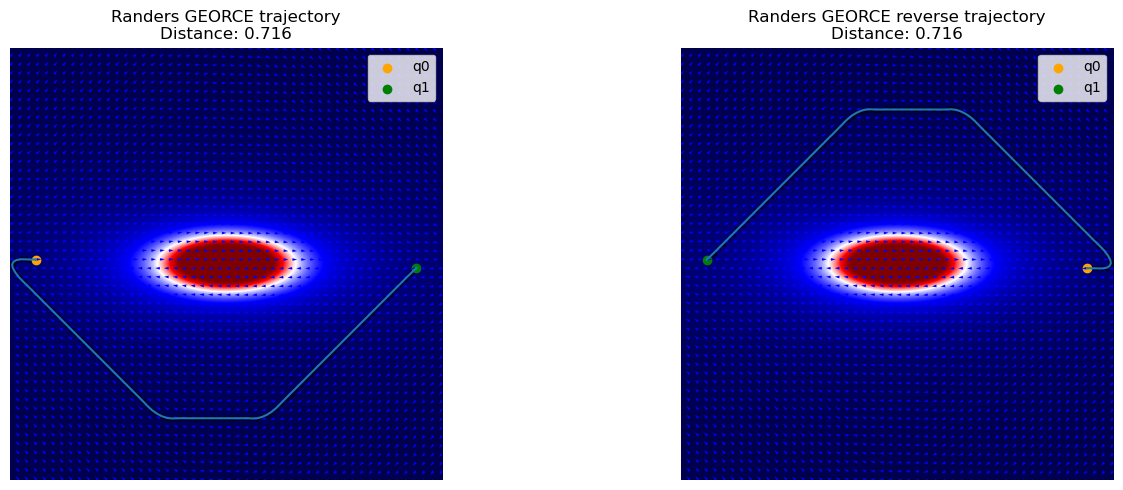

In [247]:
extent = (-l, l, -l, l)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_traj(
    x_t=traj_0_georce_rf[:, 1:-1].cpu(),
    q0=q0.cpu(),
    q1=q1.cpu(),
    extent=extent,
    ax=axes[0],
    cbar=False,
)
plot_traj(
    x_t=traj_1_georce_rf[:, 1:-1].cpu(),
    q0=q1.cpu(),
    q1=q0.cpu(),
    extent=extent,
    ax=axes[1],
    cbar=False,
)

axes[0].set_title(f"Randers GEORCE trajectory\nDistance: {dst_0_rf.item():.3f}")
axes[1].set_title(f"Randers GEORCE reverse trajectory\nDistance: {dst_1_rf.item():.3f}")

for ax in axes:
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)
    ax.quiver(
        X.numpy(),
        Y.numpy(),
        omega_[:, :, 0].numpy(),
        omega_[:, :, 1].numpy(),
        color="blue",
    )
    ax.imshow(
        mf.log(),
        extent=extent,
        origin="lower",
        cmap="seismic",
        # alpha=0.5,
        interpolation="bicubic",
    )
plt.tight_layout()
plt.show()